In [1]:
#! pip install pandas-datareader

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader as data
from datetime import date
from datetime import datetime
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
#!pip install yfinance
import yfinance as yf

## IMPORT DATASET

In [3]:
#!pip install yfinance
import yfinance as yf

In [4]:

# import realtime dataset from yahoo finance to predict future stock price

# Importing dataset
data=yf.download('CL=F', start='2000-1-1', end='2023-6-28').reset_index(drop=False)
df = pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

Date       Open       High        Low      Close  Adj Close  Volume
0 2000-08-23  31.950001  32.799999  31.950001  32.049999  32.049999   79385
1 2000-08-24  31.900000  32.240002  31.400000  31.629999  31.629999   72978
2 2000-08-25  31.700001  32.099998  31.320000  32.049999  32.049999   44601
3 2000-08-28  32.040001  32.919998  31.860001  32.869999  32.869999   46770
4 2000-08-29  32.820000  33.029999  32.560001  32.720001  32.720001   49131

In [6]:
df= df.reset_index()
df.head()

index       Date       Open       High        Low      Close  Adj Close  \
0      0 2000-08-23  31.950001  32.799999  31.950001  32.049999  32.049999   
1      1 2000-08-24  31.900000  32.240002  31.400000  31.629999  31.629999   
2      2 2000-08-25  31.700001  32.099998  31.320000  32.049999  32.049999   
3      3 2000-08-28  32.040001  32.919998  31.860001  32.869999  32.869999   
4      4 2000-08-29  32.820000  33.029999  32.560001  32.720001  32.720001   

   Volume  
0   79385  
1   72978  
2   44601  
3   46770  
4   49131

In [7]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5734 entries, 0 to 5733
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      5734 non-null   int64         
 1   Date       5734 non-null   datetime64[ns]
 2   Open       5734 non-null   float64       
 3   High       5734 non-null   float64       
 4   Low        5734 non-null   float64       
 5   Close      5734 non-null   float64       
 6   Adj Close  5734 non-null   float64       
 7   Volume     5734 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 358.5 KB


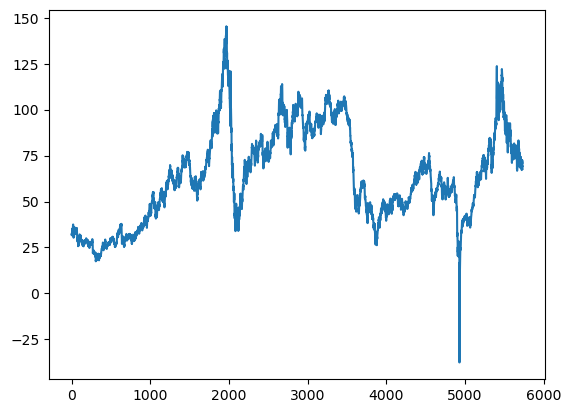

In [9]:
plt.plot(df["Close"])
plt.show()

In [10]:
# create moving average
# first 100 values are null then mean 
ma100 = df.Close.rolling(100).mean()
ma100

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
5729    74.5932
5730    74.4915
5731    74.4041
5732    74.3091
5733    74.2220
Name: Close, Length: 5734, dtype: float64

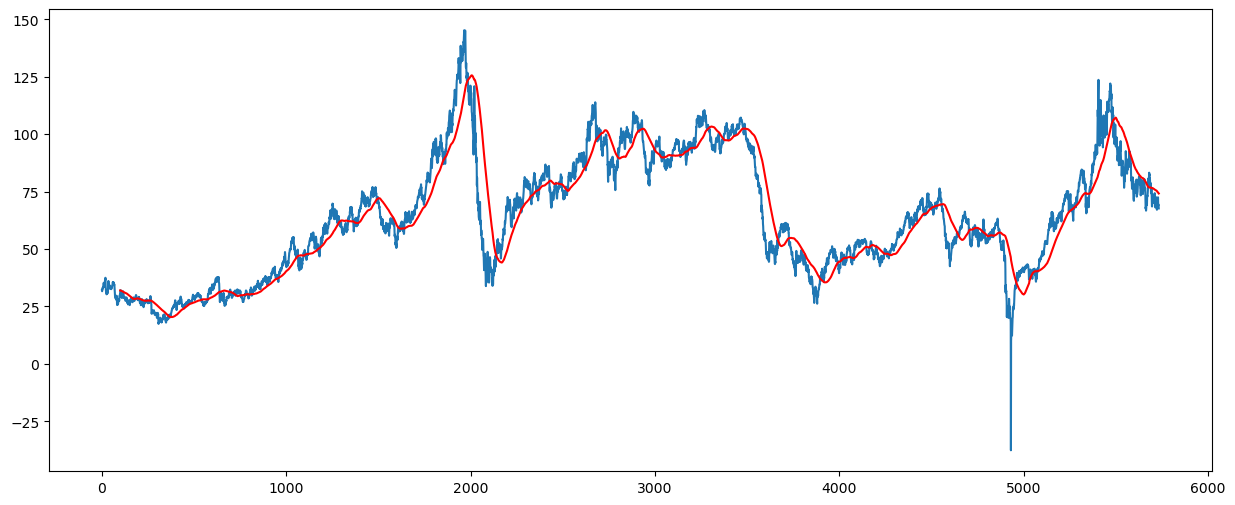

In [11]:
# plot moving average
plt.figure(figsize=(15,6))
plt.plot(df['Close'])
plt.plot(ma100, 'r')
plt.show()

In [12]:
ma200 = df.Close.rolling(200).mean()
ma200

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5729    78.33005
5730    78.24325
5731    78.15465
5732    78.09180
5733    78.01260
Name: Close, Length: 5734, dtype: float64

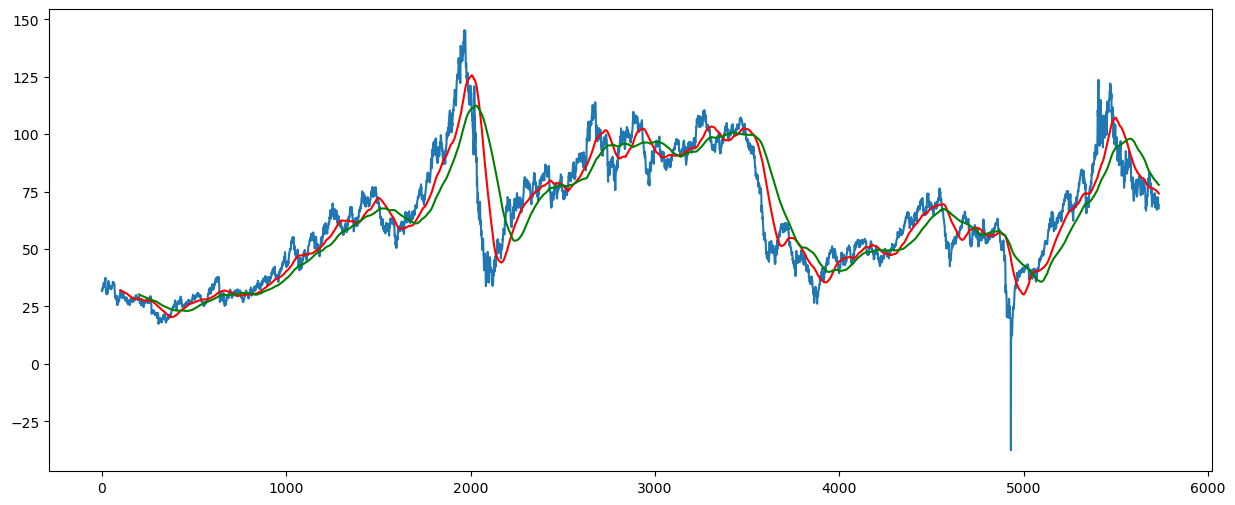

In [13]:
# plot moving average
plt.figure(figsize=(15,6))
plt.plot(df['Close'])
plt.plot(ma100, 'r')
plt.plot(ma200,'g')
plt.show()

In [14]:
df.shape

(5734, 8)

### By taking only close price for the model building purpose

In [15]:
# splitting date into training and testing 
data_training= pd.DataFrame(df['Close'][0:int(len(df)*0.70)]) # from 0 to the 70 % of the df
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70): int(len(df))]) # rest 30 % will be the testing part

print("training data: ",data_training.shape)
print("testing data: ", data_testing.shape)

training data:  (4013, 1)
testing data:  (1721, 1)


In [16]:
data_training.head()

Close
0  32.049999
1  31.629999
2  32.049999
3  32.869999
4  32.720001

In [17]:
data_testing.head()

Close
4013  47.049999
4014  48.099998
4015  46.770000
4016  47.330002
4017  47.639999

In [18]:
# scaling of data using min max scaler (0,1)

scaler = MinMaxScaler(feature_range=(0,1))

In [19]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.11420525],
       [0.11091989],
       [0.11420525],
       ...,
       [0.22950565],
       [0.24069151],
       [0.24303818]])

In [20]:
data_training_array.shape

(4013, 1)

In [21]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i]) # it will append first 100 values as input in first go and then nex 100
    y_train.append(data_training_array[i, 0]) # first output will be 101th value and so on...
    
x_train, y_train = np.array(x_train), np.array(y_train)

### MODEL BUILDING

In [22]:
# use model as sequential 
model = Sequential()
# First layer
model.add(LSTM(units= 50, activation= 'relu', return_sequences= True, # adding layers 
               input_shape= (x_train.shape[1], 1)))

model.add(Dropout(0.2))

# Second layer
model.add(LSTM(units= 60, activation= 'relu', return_sequences= True))

model.add(Dropout(0.3))

# Third layer
model.add(LSTM(units= 80, activation= 'relu', return_sequences= True))

model.add(Dropout(0.4))

# Fourth layer
model.add(LSTM(units= 120, activation= 'relu'))

model.add(Dropout(0.5))

# OUTPUT LAYER
model.add(Dense(units= 1))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [24]:
# Compile the layers in model 
model.compile(optimizer='adam', loss="mean_squared_error")


In [25]:
# fitting the model 

model.fit(x_train, y_train, epochs= 20,batch_size=200,verbose=1)

Epoch 1/20
20/20 [==============================] - 20s 683ms/step - loss: 0.0877
Epoch 2/20
20/20 [==============================] - 13s 661ms/step - loss: 0.0174
Epoch 3/20
20/20 [==============================] - 14s 677ms/step - loss: 0.0095
Epoch 4/20
20/20 [==============================] - 13s 638ms/step - loss: 0.0078
Epoch 5/20
20/20 [==============================] - 14s 713ms/step - loss: 0.0074
Epoch 6/20
20/20 [==============================] - 14s 710ms/step - loss: 0.0070
Epoch 7/20
20/20 [==============================] - 15s 761ms/step - loss: 0.0062
Epoch 8/20
20/20 [==============================] - 14s 706ms/step - loss: 0.0058
Epoch 9/20
20/20 [==============================] - 14s 711ms/step - loss: 0.0061
Epoch 10/20
20/20 [==============================] - 14s 687ms/step - loss: 0.0053
Epoch 11/20
20/20 [==============================] - 15s 750ms/step - loss: 0.0055
Epoch 12/20
20/20 [==============================] - 14s 687ms/step - loss: 0.0050
Epoch 13/20
2

In [26]:
data_testing.head()

Close
4013  47.049999
4014  48.099998
4015  46.770000
4016  47.330002
4017  47.639999

#### Now  for testing 4015 value which is first in data_testing we need past 100 values to it as a input so we use  data_training.tail(100) as a input and now 4015 value which is ( 46.77 ) is Y for past 100 

In [27]:
data_training.tail(100)

Close
3913  38.340000
3914  36.790001
3915  35.700001
3916  35.889999
3917  37.750000
...         ...
4008  45.740002
4009  46.580002
4010  46.790001
4011  48.220001
4012  48.520000

[100 rows x 1 columns]

In [28]:
past_100_days = data_training.tail(100)

In [29]:
# join past 100 values and testing dataset 

final_df= past_100_days.append(data_testing, ignore_index =True)

C:\Users\91976\AppData\Local\Temp\ipykernel_20472\779135970.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [30]:
final_df.head()

Close
0  38.340000
1  36.790001
2  35.700001
3  35.889999
4  37.750000

In [31]:
# scale the testing data as we learn the model on scaled data 

input_data = scaler.fit_transform(final_df)
input_data

array([[0.47089817],
       [0.46129054],
       [0.4545342 ],
       ...,
       [0.6619352 ],
       [0.66323688],
       [0.65288539]])

In [32]:
input_data.shape

(1821, 1)

In [33]:
x_test = []
y_test = []

for i in range (100, input_data.shape[0]):
    x_test.append(input_data[i-100 : i])
    y_test.append(input_data[i, 0])
    
x_test, y_test = np.array(x_test), np.array(y_test)    
print(x_test.shape)
print(y_test.shape)

(1721, 100, 1)
(1721,)


#### Now you can see the shape of input data and  x_test, y_test which is 1822 and 1722 , thats because 100 values go for column 

In [34]:
x_test

array([[[0.47089817],
        [0.46129054],
        [0.4545342 ],
        ...,
        [0.52327529],
        [0.53213911],
        [0.53399865]],

       [[0.46129054],
        [0.4545342 ],
        [0.4557119 ],
        ...,
        [0.53213911],
        [0.53399865],
        [0.52488689]],

       [[0.4545342 ],
        [0.4557119 ],
        [0.46724107],
        ...,
        [0.53399865],
        [0.52488689],
        [0.53139528]],

       ...,

       [[0.71610986],
        [0.72212239],
        [0.70687415],
        ...,
        [0.67024114],
        [0.68282403],
        [0.66410466]],

       [[0.72212239],
        [0.70687415],
        [0.70358892],
        ...,
        [0.68282403],
        [0.66410466],
        [0.6619352 ]],

       [[0.70687415],
        [0.70358892],
        [0.68815473],
        ...,
        [0.66410466],
        [0.6619352 ],
        [0.66323688]]])

In [35]:
# makeing predictions

y_predicted = model.predict(x_test)
y_predicted.shape

54/54 [==============================] - 5s 65ms/step


(1721, 1)

In [36]:
y_predicted

array([[0.483798  ],
       [0.48649994],
       [0.48955846],
       ...,
       [0.6320225 ],
       [0.6316504 ],
       [0.63132584]], dtype=float32)

now predicted values are in scaled format we have to up scale them by using inverse scaler 

Here we are using scaler no. which is used while scaling and then divide the predicted values with scaler ( )

for example 0.5103935 / 0.00619848 = 82.3417192602

In [37]:
scaler.scale_

array([0.00619848])

In [38]:
scaler = scaler.scale_
scaler

array([0.00619848])

In [39]:
scale_factor = 1/scaler[0]

y_predicted = y_predicted * scale_factor

y_test = y_test* scale_factor

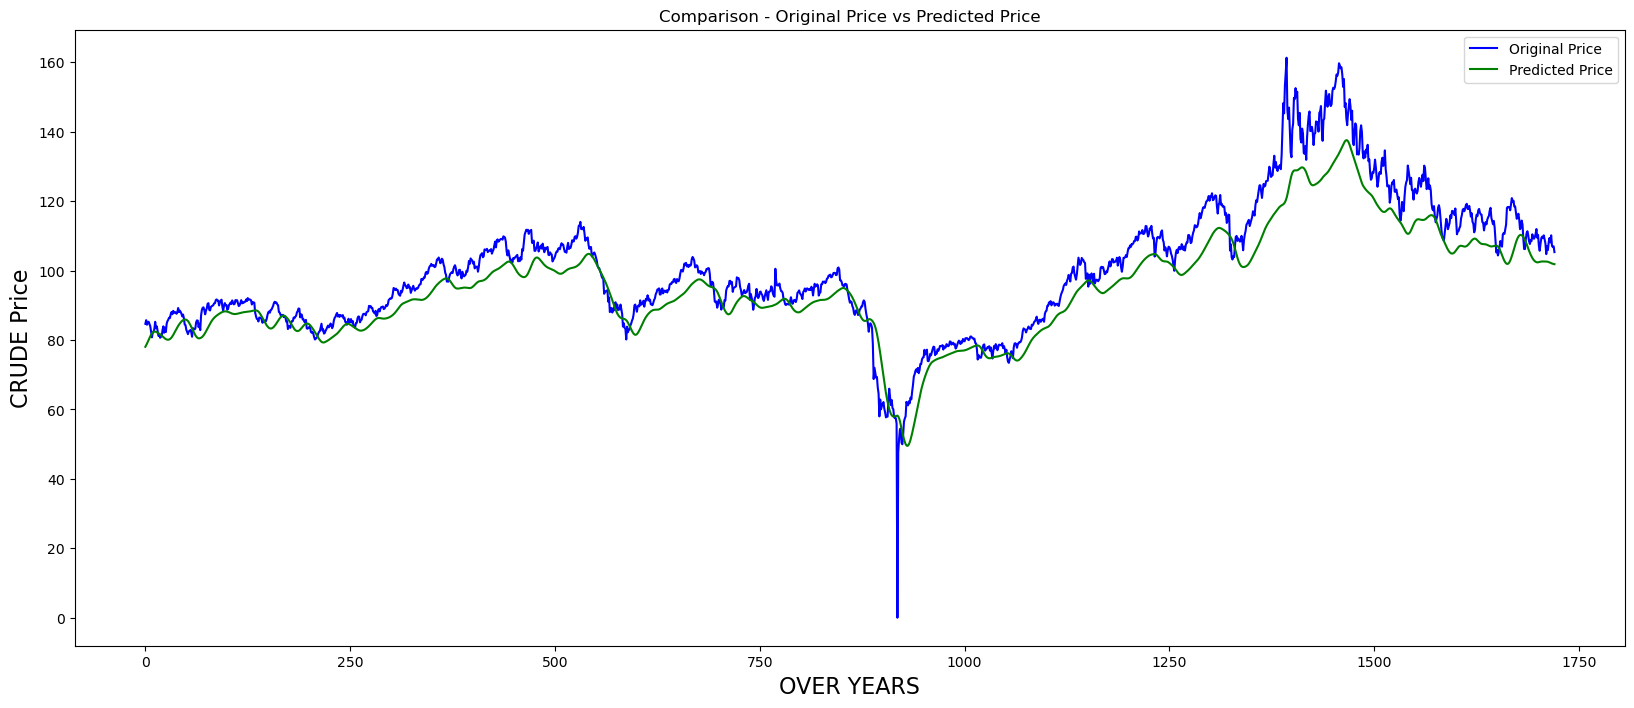

In [40]:
plt.figure(figsize = (20,8))
plt.plot(y_test, 'b', label = 'Original Price')
plt.plot(y_predicted, 'g', label = 'Predicted Price')
plt.xlabel('OVER YEARS',fontsize=16)
plt.ylabel('CRUDE Price',fontsize=16)
plt.title('Comparison - Original Price vs Predicted Price',fontsize= 12 )
plt.legend()
plt.show()

In [41]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
# Evaluation metrices RMSE and MAE

print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,y_predicted)))
print("Test data MSE: ", mean_squared_error(y_test,y_predicted))
print("Test data MAE: ", mean_absolute_error(y_test,y_predicted))

Test data RMSE:  7.581402353301729
Test data MSE:  57.47766164264899
Test data MAE:  5.907440681501847


In [42]:
y_predicted

array([[ 78.05113],
       [ 78.48704],
       [ 78.98047],
       ...,
       [101.96419],
       [101.90416],
       [101.8518 ]], dtype=float32)

In [43]:
from datetime import date

date1 = date.today()
print("Today's date:", date1)

my_time = datetime.min.time()
date1 = datetime.combine(date1, my_time)
print(date1)

Today's date: 2023-07-20
2023-07-20 00:00:00


In [44]:
date1

datetime.datetime(2023, 7, 20, 0, 0)

In [45]:
import datetime as dt

In [46]:
# Predict future price 
df1=df.reset_index()['Close']
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
datemax="24/07/2023"
datemax =dt.datetime.strptime(datemax,"%d/%m/%Y")
x_input=df1[:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

time_str = input("enter time in this format yyyy-mm-dd")
#time=datetime.datetime.strptime(time_str, "%Y-%m-%d")
#date1=str(date1)
date1=dt.datetime.strptime(time_str,"%Y-%m-%d")

nDay=date1-datemax
nDay=nDay.days
lst_output=[]
n_steps=5734
i=0

while(i<=nDay):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
res =scaler.inverse_transform(lst_output)
output = res[nDay-1]

enter time in this format yyyy-mm-dd2023-07-25
[0.56834054]
5735
1 day input [0.37863548 0.38093157 0.3854144  ... 0.58495521 0.5758255  0.56834054]
1 day output [[0.56791306]]


In [53]:
output

array([66.33084729])

## HERE WE DONE WITH THE MODEL BUILDING !

In [54]:
import pickle

In [55]:
#! pip install streamlit

In [56]:
filename= 'trained_model.sav'
pickle.dump(model,open(filename,'wb'))

In [59]:
# loading of the saved model

loaded_model = pickle.load(open('trained_model.sav','rb'))

In [58]:
forecasted = loaded_model.predict(x_test)
forecasted

54/54 [==============================] - 4s 59ms/step


array([[0.483798  ],
       [0.48649994],
       [0.48955846],
       ...,
       [0.6320225 ],
       [0.6316504 ],
       [0.63132584]], dtype=float32)